In [100]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing the data

In [101]:
from datasets import load_dataset
import pandas as pd

datasets = load_dataset("Ammok/apple_stock_price_from_1980-2021")

df = pd.DataFrame(datasets['train'])
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


# Changing Monthly order

In [102]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)



monthly_df = df.resample('M').mean() 

monthly_df.reset_index(inplace=True)

monthly_df


C:\Users\rajes\AppData\Local\Temp\ipykernel_14652\2968947801.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-31,0.136075,0.136461,0.135903,0.135903,0.106075,1.034501e+08
1,1981-01-31,0.141768,0.142086,0.141316,0.141316,0.110300,2.899947e+07
2,1981-02-28,0.118215,0.118627,0.117892,0.117892,0.092017,1.692733e+07
3,1981-03-31,0.111328,0.111683,0.110871,0.110871,0.086538,3.185076e+07
4,1981-04-30,0.121811,0.122183,0.121545,0.121545,0.094869,2.556800e+07
...,...,...,...,...,...,...,...
494,2022-02-28,169.635262,171.585263,167.580524,169.830001,169.545845,8.565875e+07
495,2022-03-31,164.806956,167.164348,162.939131,165.310435,165.067908,9.481740e+07
496,2022-04-30,167.479001,169.518500,165.083002,166.820999,166.576254,8.438978e+07
497,2022-05-31,148.324286,150.950952,145.364284,148.430477,148.385748,1.143353e+08


In [103]:
monthly_df.drop_duplicates()
monthly_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [104]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       499 non-null    datetime64[ns]
 1   Open       499 non-null    float64       
 2   High       499 non-null    float64       
 3   Low        499 non-null    float64       
 4   Close      499 non-null    float64       
 5   Adj Close  499 non-null    float64       
 6   Volume     499 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 27.4 KB


In [105]:
monthly_df['Year'] = monthly_df['Date'].dt.year
monthly_df['Month'] = monthly_df['Date'].dt.month
monthly_df.drop(columns=['Date'], inplace=True)


# PolyFea , Parameter Tuning & Cross Validation

In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np



X = monthly_df[['Year', 'Month']]
y = monthly_df['Close']


pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])


param_grid = {
    'poly__degree': [1, 2, 3],  
    'model__fit_intercept': [True, False] 
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)  

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error')


grid_search.fit(X, y)


print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {-grid_search.best_score_}')


Best Parameters: {'model__fit_intercept': True, 'poly__degree': 3}
Best Score: 137.12671861420864


# Cross validation Score

In [107]:
from sklearn.model_selection import cross_val_score

best_model = grid_search.best_estimator_
val_score = cross_val_score(best_model,X,y,cv = cv)
print(val_score)
print('Mean :',val_score.mean())

[0.85495773 0.90048766 0.85598713 0.86205533 0.8636651 ]
Mean : 0.8674305871591944


# Model Evaluation

In [108]:
from sklearn.metrics import mean_squared_error

y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error with best model: {mse}')


Mean Squared Error with best model: 126.14235076035555


# Predicting New Data

In [109]:
best_model = grid_search.best_estimator_
month = 10
year = 2024
prediction = best_model.predict([[year, month]])
print(f'Predicted Closing Price for {month}/{year}: {prediction[0]}')


Predicted Closing Price for 10/2024: 165.6475873887539


c:\Users\rajes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


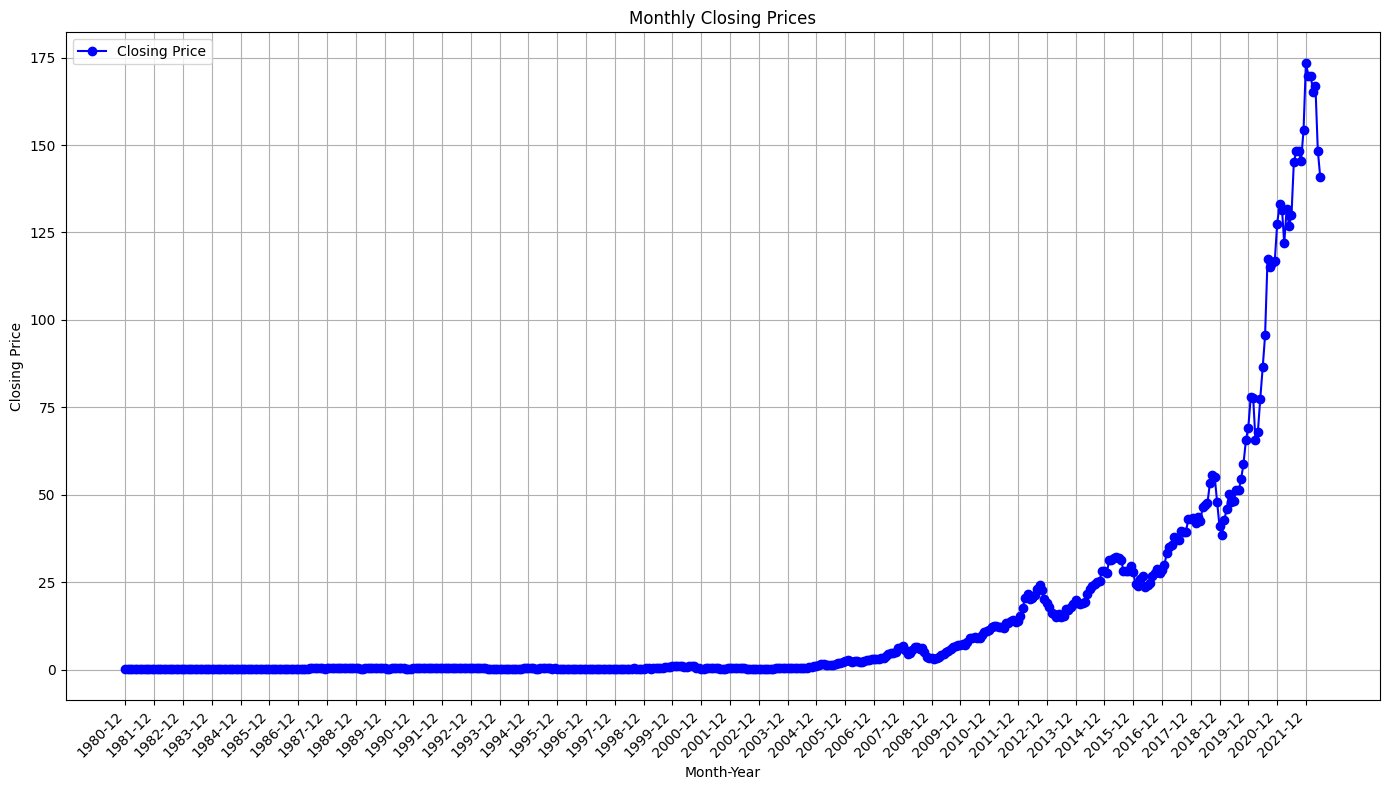

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

monthly_df['Month-Year'] = monthly_df['Year'].astype(str) + '-' + monthly_df['Month'].astype(str).str.zfill(2)
monthly_df['Month-Year'] = pd.to_datetime(monthly_df['Month-Year'], format='%Y-%m')

plt.figure(figsize=(14, 8))
plt.plot(monthly_df['Month-Year'], monthly_df['Close'], marker='o', linestyle='-', color='blue', label='Closing Price')

plt.title('Monthly Closing Prices')
plt.xlabel('Month-Year')
plt.ylabel('Closing Price')


tick_freq = 12  
plt.xticks(
    monthly_df['Month-Year'][::tick_freq], 
    monthly_df['Month-Year'].dt.strftime('%Y-%m')[::tick_freq],
    rotation=45,  
    ha='right'    
)

plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()
